# Pet Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import models, layers, utils
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

import numpy as np
import os

In [3]:
img_size = (299, 299, 3)
img_dir = "../subset_stanford_online_products"
batch_size = 32

lr_classifier = 1e-4
epoch_classifier = 10

lr_tuning = 1e-6
epoch_tuning = 12

## Prepare Dataset

<font color='red'>Apakah transfer learning dapat menggunakan skala nilai yang kita tentukan sendiri?</font>

Perhatikan bagian ini: `rescale=1. / 255`

In [4]:
train_datagen = image.ImageDataGenerator(rescale=1. / 255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode="nearest",
                                         validation_split=0.2)

# Note that the validation data should not be augmented!
test_datagen = image.ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    img_dir,
    subset="training",
    # All images will be resized to 299 x 299
    target_size=img_size[:2],
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
    shuffle=True,
    seed=1234)

validation_generator = test_datagen.flow_from_directory(
    img_dir,
    subset="validation",
    target_size=img_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=1234)

Found 9600 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


### Cek Training Dataset

In [6]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [7]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

10

In [8]:
fname = train_generator.filenames[image_idx]
fname

'table_final/301420675267_2.JPG'

In [9]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

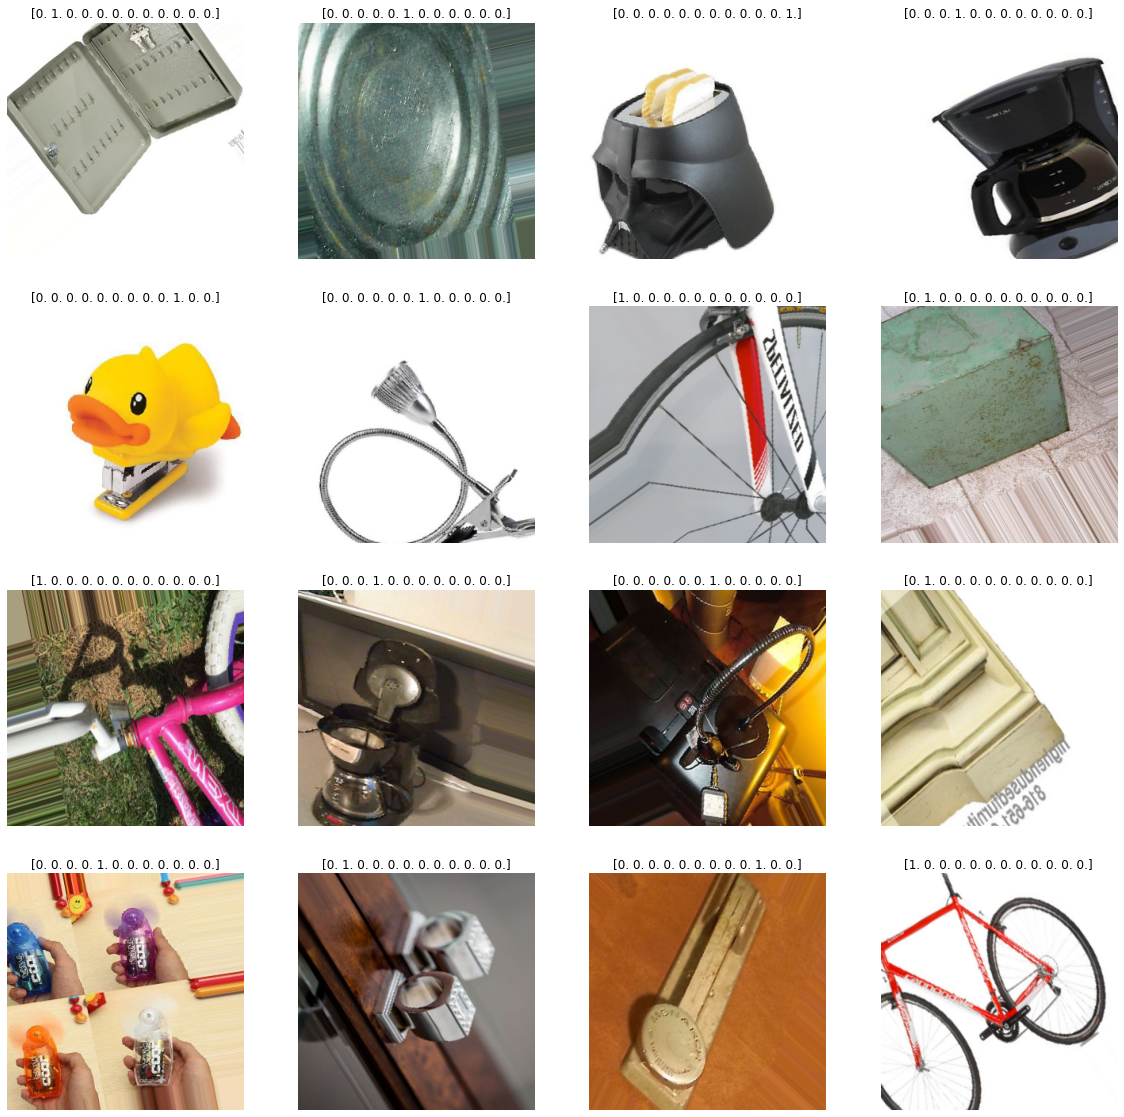

In [10]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

### Cek Validation Dataset

In [11]:
validation_generator[0][0].shape

(32, 299, 299, 3)

In [12]:
image_idx = validation_generator.index_array[1]
validation_generator.labels[image_idx]

1

In [13]:
fname = validation_generator.filenames[image_idx]
fname

'cabinet_final/141622830935_2.JPG'

In [14]:
validation_images_7, validation_labels_7 = validation_generator[7]
print(validation_images_7.shape)
print(validation_labels_7.shape)

(32, 299, 299, 3)
(32, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

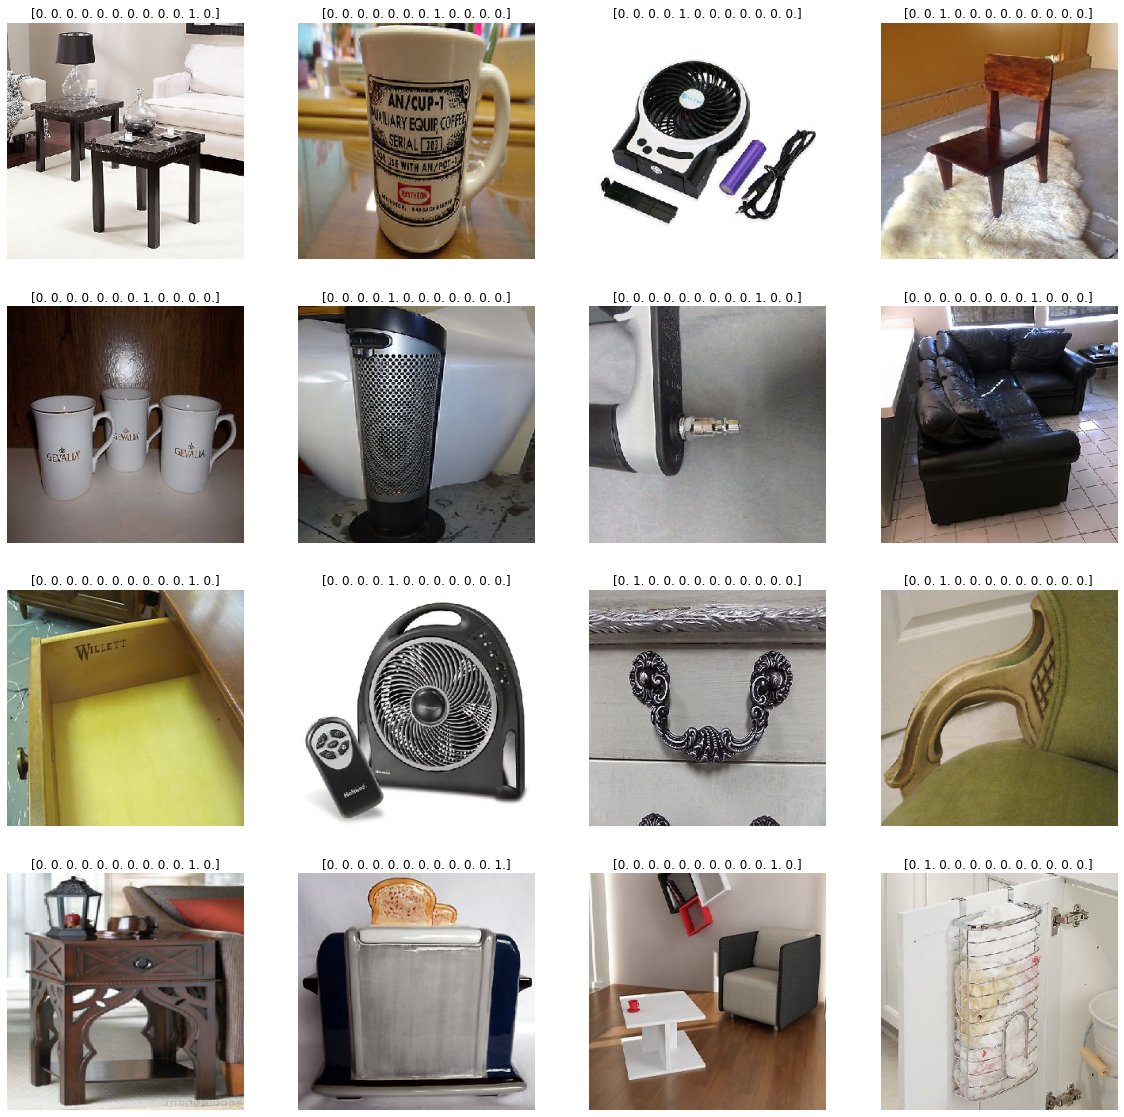

In [15]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(validation_images_7[idx]))
    plt.title(str(validation_labels_7[idx]))
    plt.axis('off')

plt.show

## Define Model with multi GPU

<font color='red'>Arsitektur seperti apa yang perlu ditambahkan pada bagian akhir Xception?</font>

In [16]:
def create_model():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = conv_base(input_layer, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [17]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [18]:
# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           xception[1][0]                   
______________________________________________________________________________________________

<font color='red'> Jumlah parameter yang di-training hanya 1jtan </font>

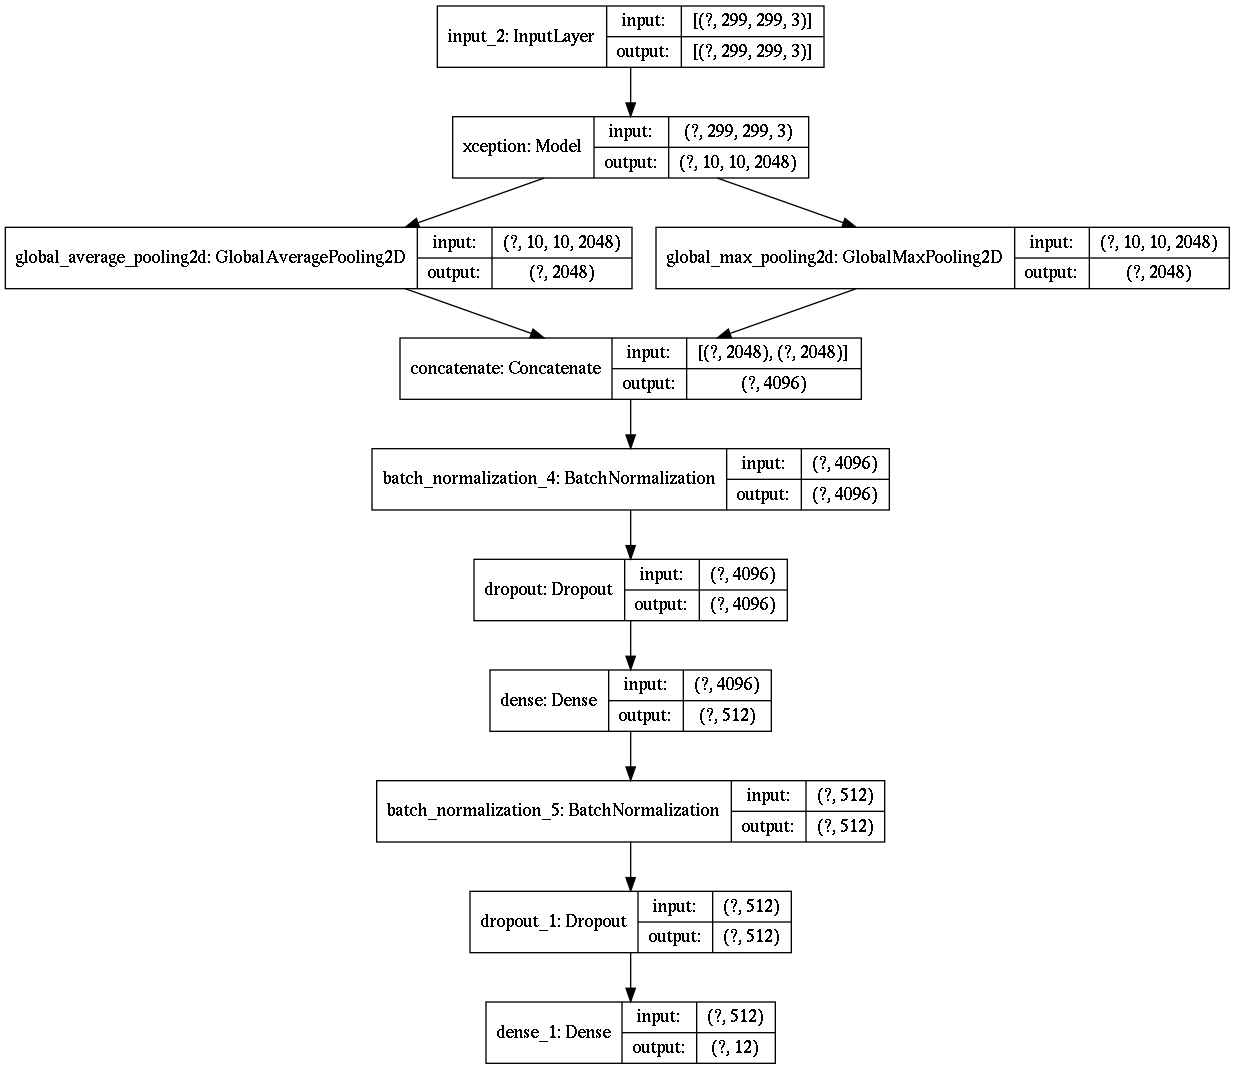

In [20]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

## Training Classifier

In [21]:
history = model.fit(train_generator,
                    epochs=epoch_classifier,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 75 steps
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
300/300 [==============================] - 143s 475ms/step - loss: 1.8204 - categorical_accuracy: 0.4998 - val_loss: 0.8231 - val_categorical_accuracy: 0.7362
Epoch 2/10
300/300 [==============================] - 134s 446ms/step - loss: 1.3401 - categorical_accuracy: 0.6276 - val_loss: 0.8187 - val_categorical_accuracy: 0.7508
Epoch 3/10
300/300 [==============================] - 134s 448ms/step - loss: 1.2244 - categorical_accuracy: 0.6517 - val_loss: 0.7908 - val_categorical_accuracy: 0.7579
Epoch 4/10
300/300 [==============================] - 134s 446ms/step - loss: 1.1404 - categori

In [22]:
model.metrics_names

['loss', 'categorical_accuracy']

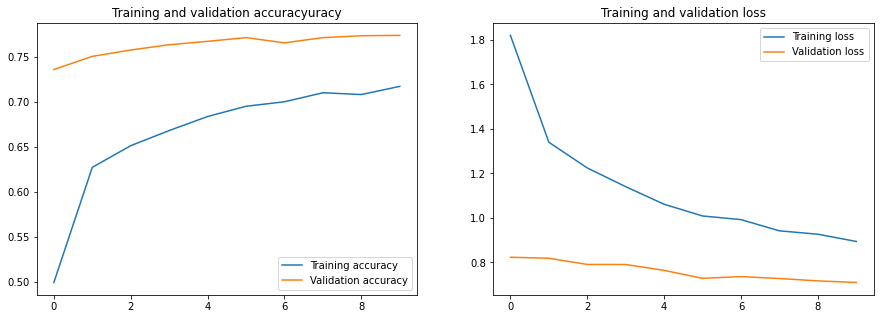

In [23]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [24]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 11s 146ms/step - loss: 0.7099 - categorical_accuracy: 0.7742


[0.7098901941378911, 0.77416664]

In [25]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [26]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 11s 141ms/step


In [27]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.98      0.94      0.96       200
     cabinet       0.80      0.83      0.81       200
       chair       0.72      0.59      0.65       200
 coffe_maker       0.70      0.75      0.73       200
         fan       0.77      0.82      0.80       200
      kettle       0.74      0.82      0.78       200
        lamp       0.71      0.71      0.71       200
         mug       0.86      0.91      0.89       200
        sofa       0.80      0.87      0.83       200
     stapler       0.78      0.73      0.75       200
       table       0.65      0.57      0.61       200
     toaster       0.75      0.74      0.75       200

    accuracy                           0.77      2400
   macro avg       0.77      0.77      0.77      2400
weighted avg       0.77      0.77      0.77      2400



In [28]:
model.save("transfer_learning_classifier.h5")

## Fine Tuning

<font color='red'>Berapa banyak layer yang perlu di-fine tune?</font>

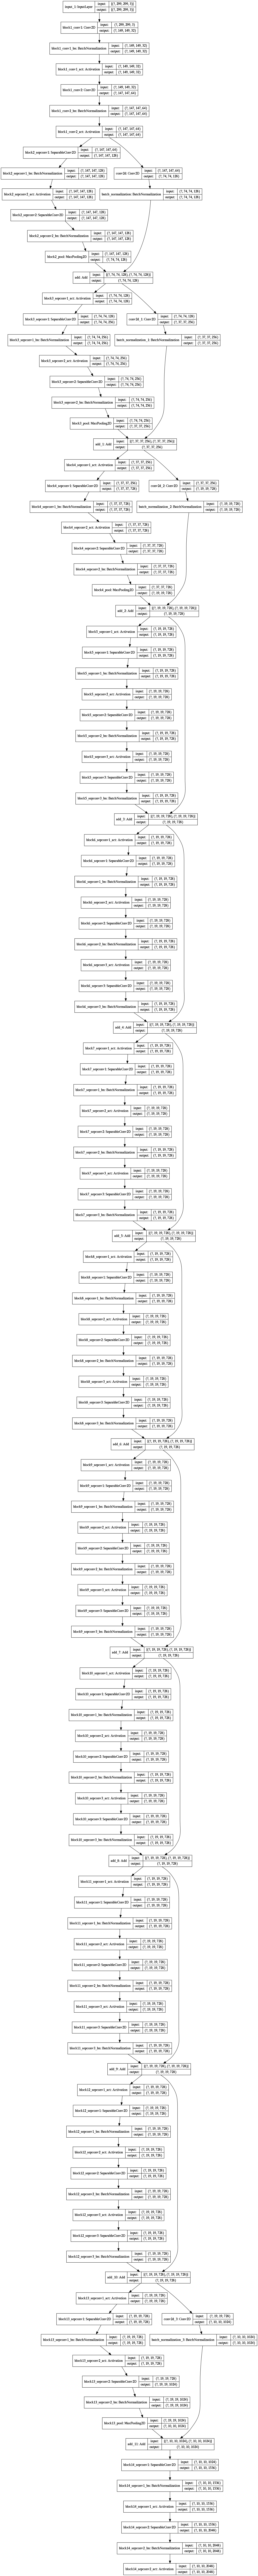

In [29]:
utils.plot_model(conv_base, show_layer_names=True, show_shapes=True)

In [30]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn False
add_3 False
bl

In [31]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'add_7':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [32]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn False
add_3 False
bl

In [33]:
with strategy.scope():
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_tuning),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=[metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           xception[1][0]                   
______________________________________________________________________________________________

In [34]:
history = model.fit(train_generator,
                    epochs=epoch_tuning,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 75 steps
Epoch 1/12
INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
300/300 [==============================] - 147s 492ms/step - loss: 0.8440 - categorical_accuracy: 0.7286 - val_loss: 0.7063 - val_categorical_accuracy: 0.7725
Epoch 2/12
300/300 [==============================] - 137s 458ms/step - loss: 0.8466 - categorical_accuracy: 0.7320 - val_loss: 0.7073 - val_categorical_accuracy: 0.7746
Epoch 3/12
300/300 [==============================] - 138s 458ms/step - loss: 0.8369 - categorical_accuracy: 0.7360 - val_loss: 0.7023 - val_categorical_accuracy: 0.7733
Epoch 4/12
300/300 [==============================] - 138s 460ms/step - loss: 0.8143 - catego

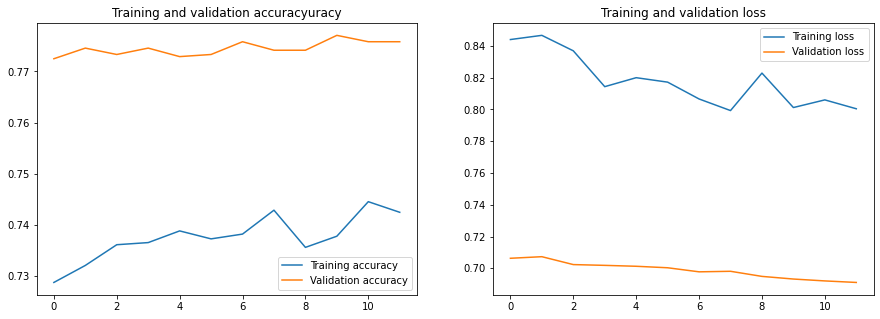

In [35]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [36]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 11s 144ms/step - loss: 0.6911 - categorical_accuracy: 0.7758


[0.6910876909891764, 0.7758333]

In [37]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [38]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 11s 142ms/step


In [39]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.98      0.94      0.96       200
     cabinet       0.78      0.83      0.81       200
       chair       0.72      0.58      0.64       200
 coffe_maker       0.71      0.76      0.73       200
         fan       0.76      0.82      0.79       200
      kettle       0.75      0.81      0.78       200
        lamp       0.74      0.71      0.73       200
         mug       0.88      0.91      0.89       200
        sofa       0.79      0.88      0.83       200
     stapler       0.78      0.74      0.76       200
       table       0.64      0.58      0.61       200
     toaster       0.76      0.74      0.75       200

    accuracy                           0.78      2400
   macro avg       0.77      0.78      0.77      2400
weighted avg       0.77      0.78      0.77      2400



In [40]:
model.save("transfer_learning_fine_tune.h5")